In [1]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
import itertools

In [2]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

# Data preprocessing

In [3]:
lines_filepath = os.path.join("cornell movie-dialogs corpus", "movie_lines.txt")
conv_filepath = os.path.join("cornell movie-dialogs corpus", "movie_conversations.txt")

In [4]:
# visualize some lines
with open(lines_filepath, 'r') as file:
    lines = file.readlines()
for line in lines[:8]:
    print(line.strip())

L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!
L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!
L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.
L984 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ She okay?
L925 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Let's go.
L924 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ Wow
L872 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Okay -- you're gonna need to learn how to lie.
L871 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ No


In [5]:
# split each file into dictionary of fields (lineID, characterID, movieID, character, text)
line_fields = ["lineID", "characterID", "movieID", "character", "text"]
lines = {}
with open(lines_filepath, 'r', encoding='iso-8859-1') as f:
    for line in f:
        values = line.split(" +++$+++ ")
        # extract fields
        lineObj = {}
        for i, field in enumerate(line_fields):
            lineObj[field] = values[i]
        lines[lineObj['lineID']] = lineObj

In [6]:
# group fields of lines from 'loadlines' into conversations based on 'movie_conversations.txt'
conv_fields = ["character1ID", "character2ID", "movieID", "utteranceIDs"]
conversations = []
with open(conv_filepath, 'r', encoding='iso-8859-1') as f:
    for line in f:
        values = line.split(" +++$+++ ")
        # extract fields
        convObj = {}
        for i, field in enumerate(conv_fields):
            convObj[field] = values[i]
        # convert string result from split to list
        lineIDs = eval(convObj['utteranceIDs'])
        # reassemble lines
        convObj["lines"] = []
        for lineID in lineIDs:
            convObj["lines"].append(lines[lineID])
        conversations.append(convObj)

In [7]:
# extract pair of sentences from conversations
qa_pairs = []
for conversation in conversations:
    # iterate over all the lines of the conversation
    for i in range(len(conversation['lines']) - 1):
        inputline = conversation["lines"][i]["text"].strip()
        targetline = conversation["lines"][i+1]["text"].strip()
        # filter wrong samples (if one of lists is empty)
        if inputline and targetline:
            qa_pairs.append([inputline, targetline])

In [8]:
# Define path to new file
datafile = os.path.join("cornell movie-dialogs corpus", "formatted_movie_lines.txt")
delimiter = '\t'
# Unescape the delimiter
delimiter = str(codecs.decode(delimiter, "unicode_escape"))

# Write new csv file
print("\nWriting newly formatted file...")
with open(datafile, 'w', encoding='utf-8') as outputfile:
    writer = csv.writer(outputfile, delimiter=delimiter)
    for pair in qa_pairs:
        writer.writerow(pair)
print("Done writing to file")


Writing newly formatted file...
Done writing to file


In [9]:
datafile = os.path.join("cornell movie-dialogs corpus", "formatted_movie_lines.txt")
with open(datafile, 'rb') as file:
    lines = file.readlines()
for line in lines[:8]:
    print(line.strip())

b"Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.\tWell, I thought we'd start with pronunciation, if that's okay with you."
b"Well, I thought we'd start with pronunciation, if that's okay with you.\tNot the hacking and gagging and spitting part.  Please."
b"Not the hacking and gagging and spitting part.  Please.\tOkay... then how 'bout we try out some French cuisine.  Saturday?  Night?"
b"You're asking me out.  That's so cute. What's your name again?\tForget it."
b"No, no, it's my fault -- we didn't have a proper introduction ---\tCameron."
b"Cameron.\tThe thing is, Cameron -- I'm at the mercy of a particularly hideous breed of loser.  My sister.  I can't date until she does."
b"The thing is, Cameron -- I'm at the mercy of a particularly hideous breed of loser.  My sister.  I can't date until she does.\tSeems like she could get a date easy enough..."
b'Why?\tUnsolved mystery.  She used to be really po

In [10]:
# Default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

class Vocabulary:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        keep_words = []
        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3 # Count default tokens

        for word in keep_words:
            self.addWord(word)

In [11]:
#Turn a Unicode string to plain ASCII, thanks to
def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

In [12]:
# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

In [13]:
print("Reading lines...")
# Read the file and split into lines
lines = open(datafile, encoding='utf-8').read().strip().split('\n')
# Split every line into pairs and normalize
pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
print("Done Reading.")
voc = Vocabulary("cornell movie-dialogs corpus")

Reading lines...
Done Reading.


In [14]:
MAX_LENGTH = 10  # Maximum sentence length to consider
# Returns True iff both sentences in a pair 'p' are under the MAX_LENGTH threshold
def filterPair(p):
    # Input sequences need to preserve the last word for EOS token
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

# Filter pairs using filterPair condition
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [15]:
pairs = [pair for pair in pairs if len(pair)>1]
print(f"There are {len(pairs)} pairs/conversations in dataset")
pairs = filterPairs(pairs)
print(f"After filtering, there are {len(pairs)} pairs/conversations in dataset")

There are 221282 pairs/conversations in dataset
After filtering, there are 64271 pairs/conversations in dataset


In [16]:
# loop through each pair of and add question and reply sentence to vocabulary
for pair in pairs:
    voc.addSentence(pair[0])
    voc.addSentence(pair[1])
print("Counted words:", voc.num_words)
for pair in pairs[:10]:
    print(pair)

Counted words: 18008
['there .', 'where ?']
['you have my word . as a gentleman', 'you re sweet .']
['hi .', 'looks like things worked out tonight huh ?']
['you know chastity ?', 'i believe we share an art instructor']
['have fun tonight ?', 'tons']
['well no . . .', 'then that s all you had to say .']
['then that s all you had to say .', 'but']
['but', 'you always been this selfish ?']
['do you listen to this crap ?', 'what crap ?']
['what good stuff ?', 'the real you .']


In [17]:
MIN_COUNT = 3    # Minimum word count threshold for trimming

def trimRareWords(voc, pairs, MIN_COUNT):
    # Trim words used under the MIN_COUNT from the voc
    voc.trim(MIN_COUNT)
    # Filter out pairs with trimmed words
    keep_pairs = []
    for pair in pairs:
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        # Check input sentence
        for word in input_sentence.split(' '):
            if word not in voc.word2index:
                keep_input = False
                break
        # Check output sentence
        for word in output_sentence.split(' '):
            if word not in voc.word2index:
                keep_output = False
                break

        # Only keep pairs that do not contain trimmed word(s) in their input or output sentence
        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("Trimmed from {} pairs to {}, {:.4f} of total".format(len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
    return keep_pairs


# Trim voc and pairs
pairs = trimRareWords(voc, pairs, MIN_COUNT)

keep_words 7823 / 18005 = 0.4345
Trimmed from 64271 pairs to 53165, 0.8272 of total


If you’re interested in speeding up training and/or would like to leverage GPU parallelization capabilities, you will need to train with mini-batches.
Using mini-batches also means that we must be mindful of the variation of sentence length in our batches. To accommodate sentences of different sizes in the same batch, we will make our batched input tensor of shape (max_length, batch_size), where sentences shorter than the max_length are zero padded after an EOS_token.
If we simply convert our English sentences to tensors by converting words to their indexes(indexesFromSentence) and zero-pad, our tensor would have shape (batch_size, max_length) and indexing the first dimension would return a full sequence across all time-steps. However, we need to be able to index our batch along time, and across all sequences in the batch. Therefore, we transpose our input batch shape to (max_length, batch_size), so that indexing across the first dimension returns a time step across all sentences in the batch. We handle this transpose implicitly in the zeroPadding function.

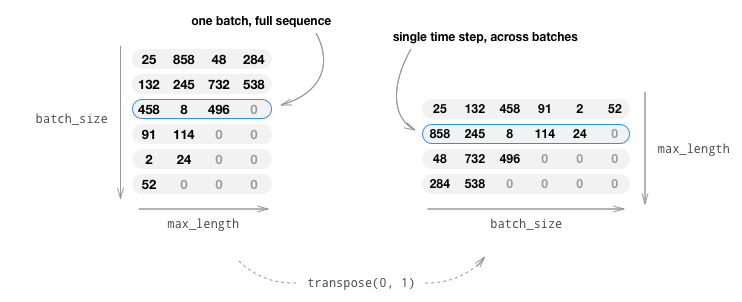

In [18]:
def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]

In [19]:
# test the above function
indexesFromSentence(voc, pairs[1][0])

[7, 8, 9, 10, 4, 11, 12, 13, 2]

In [20]:
# define some samples for testing
inp, out = [], []
for pair in pairs[:10]:
    inp.append(pair[0])
    out.append(pair[1])
print(inp)
print(len(inp))
print(out)
indexes = [indexesFromSentence(voc, sentence) for sentence in inp]
indexes

['there .', 'you have my word . as a gentleman', 'hi .', 'have fun tonight ?', 'well no . . .', 'then that s all you had to say .', 'but', 'do you listen to this crap ?', 'what good stuff ?', 'wow']
10
['where ?', 'you re sweet .', 'looks like things worked out tonight huh ?', 'tons', 'then that s all you had to say .', 'but', 'you always been this selfish ?', 'what crap ?', 'the real you .', 'let s go .']


[[3, 4, 2],
 [7, 8, 9, 10, 4, 11, 12, 13, 2],
 [16, 4, 2],
 [8, 31, 22, 6, 2],
 [33, 34, 4, 4, 4, 2],
 [35, 36, 37, 38, 7, 39, 40, 41, 4, 2],
 [42, 2],
 [47, 7, 48, 40, 45, 49, 6, 2],
 [50, 51, 52, 6, 2],
 [58, 2]]

In [21]:
def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

In [22]:
leng = [len(idx) for idx in indexes]
max(leng)

10

In [23]:
# test zeroPadding function
test_result = zeroPadding(indexes)
print(len(test_result)) # max length is number of rows
test_result

10


[(3, 7, 16, 8, 33, 35, 42, 47, 50, 58),
 (4, 8, 4, 31, 34, 36, 2, 7, 51, 2),
 (2, 9, 2, 22, 4, 37, 0, 48, 52, 0),
 (0, 10, 0, 6, 4, 38, 0, 40, 6, 0),
 (0, 4, 0, 2, 4, 7, 0, 45, 2, 0),
 (0, 11, 0, 0, 2, 39, 0, 49, 0, 0),
 (0, 12, 0, 0, 0, 40, 0, 6, 0, 0),
 (0, 13, 0, 0, 0, 41, 0, 2, 0, 0),
 (0, 2, 0, 0, 0, 4, 0, 0, 0, 0),
 (0, 0, 0, 0, 0, 2, 0, 0, 0, 0)]

In [24]:
def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

In [25]:
binary_result = binaryMatrix(test_result)
binary_result

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 0, 1, 1, 0],
 [0, 1, 0, 1, 1, 1, 0, 1, 1, 0],
 [0, 1, 0, 1, 1, 1, 0, 1, 1, 0],
 [0, 1, 0, 0, 1, 1, 0, 1, 0, 0],
 [0, 1, 0, 0, 0, 1, 0, 1, 0, 0],
 [0, 1, 0, 0, 0, 1, 0, 1, 0, 0],
 [0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]]

In [26]:
# Returns padded input sequence tensor and lengths
def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

In [27]:
# Returns padded target sequence tensor, padding mask, and max target length
def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.BoolTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

In [28]:
# Returns all items for a given batch of pairs
def batch2TrainData(voc, pair_batch):
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len

In [29]:
# Example for validation
small_batch_size = 5
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len = batches

print("input_variable:", input_variable)
print("lengths:", lengths)
print("target_variable:", target_variable)
print("mask:", mask)
print("max_target_len:", max_target_len)

input_variable: tensor([[1235,  147,  158, 1125,   75],
        [   3,    8,   70,  577,   50],
        [  37,    7, 5543, 1205,    6],
        [  53,   44,  177,    4,    2],
        [5115,    6,    4,    2,    0],
        [   4,    2,    2,    0,    0],
        [   4,    0,    0,    0,    0],
        [   4,    0,    0,    0,    0],
        [   2,    0,    0,    0,    0]])
lengths: tensor([9, 6, 6, 5, 4])
target_variable: tensor([[   3,    4,   50,  424,  167],
        [  37,    4,   98,   83,   25],
        [  53,    4,    6,   12,  296],
        [5115,    7,    2, 3587,   75],
        [   4,   24,    0,  115,   36],
        [   2,   83,    0,  319,    4],
        [   0,    6,    0, 2278,    2],
        [   0,    2,    0,    4,    0],
        [   0,    0,    0,    2,    0]])
mask: tensor([[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True, Fal

# Define Models

The goal of a seq2seq model is to take a variable-length sequence as an input, and return a variable-length sequence as an output using a fixed-sized model.

We can accomplish this task by using two separate recurrent neural nets together. One RNN acts as an encoder, which encodes a variable length input sequence to a fixed-length context vector. In theory, this context vector (the final hidden layer of the RNN) will contain semantic information about the query sentence that is input to the bot. The second RNN is a decoder, which takes an input word and the context vector, and returns a guess for the next word in the sequence and a hidden state to use in the next iteration.

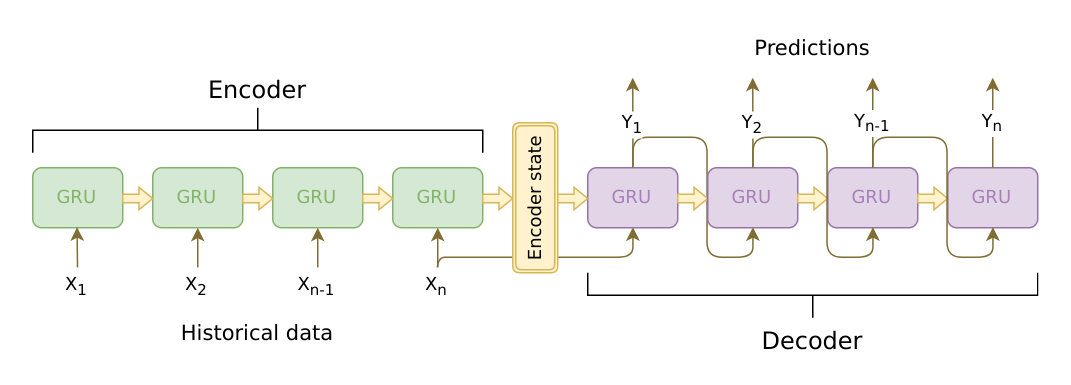

We will use a bidirectional variant of the GRU, meaning that there are essentially two independent RNNs: one that is fed the input sequence in normal sequential order, and one that is fed the input sequence in reverse order. The outputs of each network are summed at each time step. Using a bidirectional GRU will give us the advantage of encoding both past and future contexts.

The steps to be done are: convert word indexes to embeddings, pack padded batch of sequences for RNN module, forward pass through GRU, unpack padding, sum bidirectional GRU outputs and return output and final hidden state

In [30]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size params are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        # input_seq: batch of input sentences; shape=(max_length, batch_size)
        # input_lengths: list of sentence lengths corresponding to each sentence in the batch; shape=(batch_size)
        # hidden: hidden state; shape=(n_layers x num_directions, batch_size, hidden_size)
        # Convert word indexes to embeddings
        embedded = self.embedding(input_seq)
        # Pack padded batch of sequences for RNN module
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        # Sum bidirectional GRU outputs
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        # Return output and final hidden state
        return outputs, hidden
        # outputs: output features from the last hidden layer of the GRU (sum of bidirectional outputs); shape=(max_length, batch_size, hidden_size)
        # hidden: updated hidden state from GRU; shape=(n_layers x num_directions, batch_size, hidden_size)

# Decoder

The decoder RNN generates the response sentence in a token-by-token fashion. It continues generating words until it outputs an EOS_token, representing the end of the sentence. We will use “attention mechanism” that allows the decoder to pay attention to certain parts of the input sequence, rather than using the entire fixed context at every step. At a high level, attention is calculated using the decoder’s current hidden state and the encoder’s outputs. We will also use “Global attention”, where we consider all of the encoder’s hidden states, as opposed to “Local attention”, which only considers the encoder’s hidden state from the current time step, as well as calculate attention weights, using the hidden state of the decoder from the current time step only. The output of this module is a softmax normalized weights tensor of shape (batch_size, 1, max_length).

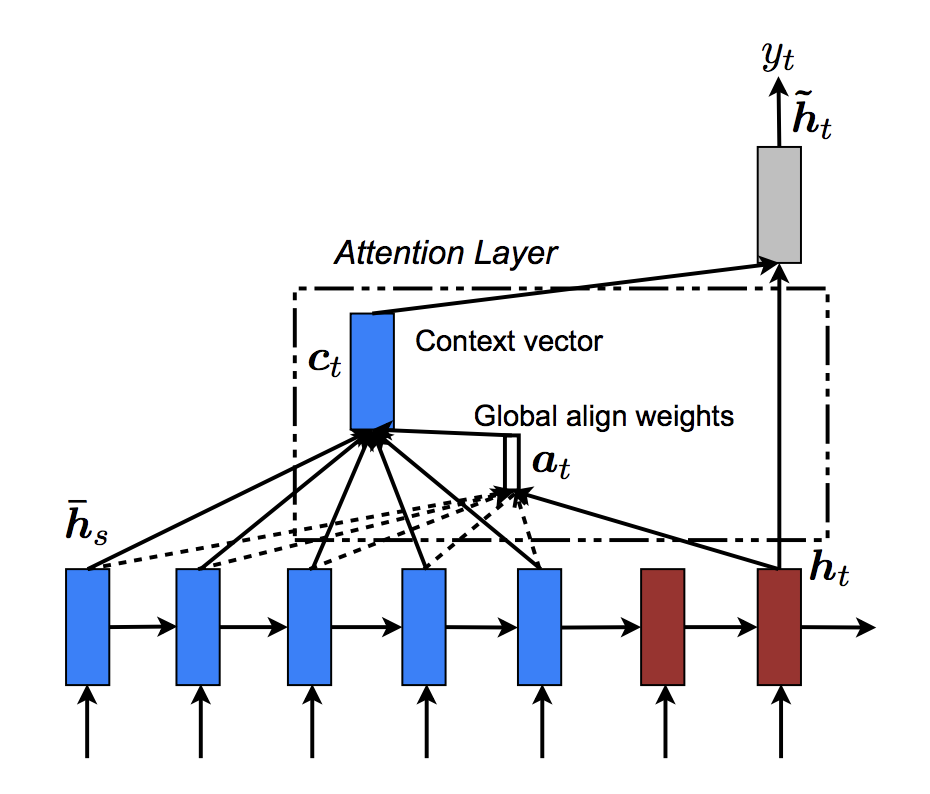

In "Global Attention", there are various methods to calculate the attention energies between the encoder output and decoder output which are called “score functions”: ht is the current target decoder state and hs_bar is all encoder states.

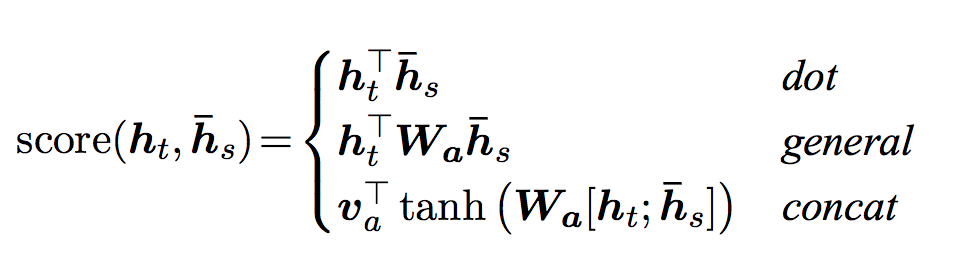

In [31]:
# Luong attention layer
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        self.hidden_size = hidden_size

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def forward(self, hidden, encoder_outputs):
        # hidden of shape: (1, batch_size, hidden_size)
        # encoder_outputs of shape=(max_length, batch_size, hidden_size)
        # Calculate the attention weights (energies) based on the given method
        attn_energies = self.dot_score(hidden, encoder_outputs) # shape=(max_length, batch_size)
        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t() # shape=(batch_size, max_length)
        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1) # shape=(batch_size, 1, max_length)

For the decoder, we will manually feed our batch one time step at a time. This means that our embedded word tensor and GRU output will both have shape (1, batch_size, hidden_size). The steps are: get embedding of current input word, forward through unidirectional GRU, calculate attention weights from the current GRU output, multiply attention weights to encoder outputs to get new “weighted sum” context vector, concatenate weighted context vector and GRU output, predict next word and finally, return output and final hidden state.

In [32]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # input_step: one time step (one word) of input sequence batch; shape=(1, batch_size)
        # last_hidden:final hidden state of encoder GRU; shape=(n_layers * num_directions, batch_size, hidden_size)
        # encoder_outputs: encoder model's output; shape=(seq_len, batch, num_directions * hidden_size)
        
        # Note: we run this one step (word) at a time
        # Get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # rnn_output shape: (1, batch, num_directions * hidden_size)
        # hidden shape: (num_directions * n_layers, batch, hidden_size)
        
        # Calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        # (batch_size, 1, max_length) bmm with (batch_size, max_length, hidden) = (batch_size, 1, hidden)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # Predict next word using Luong eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # Return output and final hidden state
        return output, hidden
        # output: softmax normalized tensor giving probabilities of each wordbeing the correct next word in the decoded sequence
        # output shape=(batch_size, voc.num_words)
        # hidden: final hidden state of GRU; shape=(n_layers * num_directions, batch_size, hidden_size)

# Define Training Procedure

Since we are dealing with batches of padded sequences, we cannot simply consider all elements of the tensor when calculating loss. We define maskNLLLoss to calculate our loss based on our decoder’s output tensor, the target tensor, and a binary mask tensor describing the padding of the target tensor. This loss function calculates the average negative log likelihood of the elements that correspond to a 1 in the mask tensor.

In [33]:
def maskNLLLoss(decoder_out, target, mask):
    # decoder shape: (batch_size, voc_size)
    # target shape: (batch_size, 1)
    nTotal = mask.sum() # how many elements should be considered
    # calculate Negative Log Likelihood loss
    crossEntropy = -torch.log(torch.gather(decoder_out, 1, target.view(-1, 1)).squeeze(1))
    # select non-zero elements, and calculate their mean of the loss
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

We will use a couple of clever tricks to aid in convergence:
The first trick is using teacher forcing. This means that at some probability, set by teacher_forcing_ratio, we use the current target word as the decoder’s next input rather than using the decoder’s current guess. This technique acts as training wheels for the decoder, aiding in more efficient training. However, teacher forcing can lead to model instability during inference, as the decoder may not have a sufficient chance to truly craft its own output sequences during training. Thus, we must be mindful of how we are setting the teacher_forcing_ratio, and not be fooled by fast convergence.
The second trick that we implement is gradient clipping. This is a commonly used technique for countering the “exploding gradient” problem. In essence, by clipping or thresholding gradients to a maximum value, we prevent the gradients from growing exponentially and either overflow (NaN), or overshoot steep cliffs in the cost function.

The training steps are: forward pass entire input batch through encoder, initialize decoder inputs as SOS_token, and hidden state as the encoder’s final hidden state, forward input batch sequence through decoder one time step at a time, if teacher forcing: set next decoder input as the current target; else: set next decoder input as current decoder output, calculate and accumulate loss, perform backpropagation, clip gradients and update encoder and decoder model parameters

In [34]:
# visualizing what's happening in one iteration, only for visualization
small_batch_size = 5
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len = batches

print("input_variable shape: ", input_variable.shape)
print("lengths shape:", lengths.shape)
print("target_variable shape: ", target_variable.shape)
print("mask shape:", mask.shape)
print("max_target_len:", max_target_len)

# Define the parameters
hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
learning_rate = 0.0001
attn_model = 'dot'
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, hidden_size)

# Define encoder & decoder models
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
encoder = encoder.to(device)
decoder = decoder.to(device)
# Ensure dropout layers are in train mode
encoder.train()
decoder.train()

# Initialize optimizers
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
# Zero gradients
encoder_optimizer.zero_grad()
decoder_optimizer.zero_grad()

# Set device options
input_variable = input_variable.to(device)
target_variable = target_variable.to(device)
mask = mask.to(device)
# Lengths for rnn packing should always be on the cpu
lengths = lengths.to("cpu")

loss = 0
print_losses = []
n_totals = 0

# Forward pass through encoder
encoder_outputs, encoder_hidden = encoder(input_variable, lengths)
print("encoder_outputs shape:", encoder_outputs.shape)
print("last encoder_hidden shape:", input_variable.shape)

# Create initial decoder input (start with SOS tokens for each sentence)
decoder_input = torch.LongTensor([[SOS_token for _ in range(small_batch_size)]])
decoder_input = decoder_input.to(device)
print("initial decoder_input shape:", decoder_input.shape)
print(decoder_input)

# Set initial decoder hidden state to the encoder's final hidden state
decoder_hidden = encoder_hidden[:decoder.n_layers]
print("initial decoder_hidden state shape: ", decoder_hidden.shape)
print("-----------------------------------------------------------------")
print("\n")
print("Next step is to see what's happening in every timestep of GRU")
print("-----------------------------------------------------------------")
print("\n")

# Assume we use teacher forcing
for t in range(max_target_len):
    decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
    print("decoder_output shape: ", decoder_output.shape)
    print("decoder_hidden shape: ", decoder_hidden.shape)
    # teacher forcing - next input is current target
    decoder_input = target_variable[t].view(1, -1)
    print("The current variable at the current timestep before reshaping: ", target_variable[t])
    print("The current variable at the current timestep shape before reshaping: ", target_variable[t].shape)
    print("The decoder input shape (reshape the target variable): ", decoder_input.shape)
    # calculate and accumulate loss
    print("The mask at the current timestep: ", mask[t])
    print("The mask at the current timestep shape: ", mask[t].shape)
    mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
    print("mask loss: ", mask_loss)
    print("total: ", nTotal)
    loss += mask_loss
    print_losses.append(mask_loss.item() * nTotal)
    print(print_losses)
    n_totals += nTotal
    print(n_totals)
    encoder_optimizer.step()
    decoder_optimizer.step()
    returned_loss = sum(print_losses) / n_totals
    print("returned loss: ", returned_loss)
    print("\n")
    print("---------------------- Done One Timestep -------------------")
    print("\n")

input_variable shape:  torch.Size([10, 5])
lengths shape: torch.Size([5])
target_variable shape:  torch.Size([8, 5])
mask shape: torch.Size([8, 5])
max_target_len: 8
encoder_outputs shape: torch.Size([10, 5, 500])
last encoder_hidden shape: torch.Size([10, 5])
initial decoder_input shape: torch.Size([1, 5])
tensor([[1, 1, 1, 1, 1]])
initial decoder_hidden state shape:  torch.Size([2, 5, 500])
-----------------------------------------------------------------


Next step is to see what's happening in every timestep of GRU
-----------------------------------------------------------------


decoder_output shape:  torch.Size([5, 7826])
decoder_hidden shape:  torch.Size([2, 5, 500])
The current variable at the current timestep before reshaping:  tensor([ 192,   77, 2726,  339,   25])
The current variable at the current timestep shape before reshaping:  torch.Size([5])
The decoder input shape (reshape the target variable):  torch.Size([1, 5])
The mask at the current timestep:  tensor([True, T

In [35]:
def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding,
          encoder_optimizer, decoder_optimizer, batch_size, clip, max_length=MAX_LENGTH):

    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Set device options
    input_variable = input_variable.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)
    # Lengths for rnn packing should always be on the cpu
    lengths = lengths.to("cpu")

    # Initialize variables
    loss = 0
    print_losses = []
    n_totals = 0

    # Forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # Create initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # Set initial decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    # Determine if we are using teacher forcing this iteration
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # Forward batch of sequences through decoder one time step at a time
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # Teacher forcing: next input is current target
            decoder_input = target_variable[t].view(1, -1)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # No teacher forcing: next input is decoder's own current output
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    # Perform backpropatation
    loss.backward()

    # Clip gradients: gradients are modified in place
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals

We save a tarball containing the encoder and decoder state_dicts (parameters), the optimizers’ state_dicts, the loss, the iteration, etc. Saving the model in this way will give us the ultimate flexibility with the checkpoint. After loading a checkpoint, we will be able to use the model parameters to run inference, or we can continue training right where we left off.

In [36]:
def trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size, print_every, save_every, clip, corpus_name, loadFilename):
    # Load batches for each iteration
    training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]

    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    if loadFilename:
        start_iteration = checkpoint['iteration'] + 1

    # Training loop
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        # Extract fields from batch
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        # Run a training iteration with batch
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip)
        print_loss += loss

        # Print progress
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0

        # Save checkpoint
        if (iteration % save_every == 0):
            directory = os.path.join(save_dir, model_name, corpus_name, '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size))
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'loss': loss,
                'voc_dict': voc.__dict__,
                'embedding': embedding.state_dict()
            }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))

Greedy decoding is the decoding method that we use during training when we are NOT using teacher forcing. In other words, for each time step, we simply choose the word from decoder_output with the highest softmax value. This decoding method is optimal on a single time-step level.

To facilitate the greedy decoding operation, we define a GreedySearchDecoder class. When run, an object of this class takes an input sequence (input_seq) of shape (input_seq length, 1), a scalar input length (input_length) tensor, and a max_length to bound the response sentence length.

In [37]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        # Forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # Prepare encoder's final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        # Initialize tensors to append decoded words to
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        # Iteratively decode one word token at a time
        for _ in range(max_length):
            # Forward pass through decoder
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Obtain most likely word token and its softmax score
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # Record token and score
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # Prepare current token to be next decoder input (add a dimension)
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # Return collections of word tokens and scores
        return all_tokens, all_scores

# Evaluation

The evaluate function manages the low-level process of handling the input sentence. We first format the sentence as an input batch of word indexes with batch_size==1. We do this by converting the words of the sentence to their corresponding indexes, and transposing the dimensions to prepare the tensor for our models. We also create a lengths tensor which contains the length of our input sentence. In this case, lengths is scalar because we are only evaluating one sentence at a time (batch_size==1). Next, we obtain the decoded response sentence tensor using our GreedySearchDecoder object (searcher). Finally, we convert the response’s indexes to words and return the list of decoded words.

evaluateInput acts as the user interface for our chatbot. When called, an input text field will spawn in which we can enter our query sentence. After typing our input sentence and pressing Enter, our text is normalized in the same way as our training data, and is ultimately fed to the evaluate function to obtain a decoded output sentence. We loop this process, so we can keep chatting with our bot until we enter either “q” or “quit”.

In [38]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH):
    ### Format input sentence as a batch
    # words -> indexes
    indexes_batch = [indexesFromSentence(voc, sentence)]
    # Create lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # Transpose dimensions of batch to match models' expectations
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    # Use appropriate device
    input_batch = input_batch.to(device)
    lengths = lengths.to("cpu")
    # Decode sentence with searcher
    tokens, scores = searcher(input_batch, lengths, max_length)
    # indexes -> words
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words


def evaluateInput(encoder, decoder, searcher, voc):
    input_sentence = ''
    while(1):
        try:
            # Get input sentence
            input_sentence = input('> ')
            # Check if it is quit case
            if input_sentence == 'q' or input_sentence == 'quit': break
            # Normalize sentence
            input_sentence = normalizeString(input_sentence)
            # Evaluate sentence
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
            # Format and print response sentence
            output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            print('Bot:', ' '.join(output_words))

        except KeyError:
            print("Error: Encountered unknown word.")

# Running the model

In [39]:
# Configure models
model_name = 'cb_model'
attn_model = 'dot'
#attn_model = 'general'
#attn_model = 'concat'
hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
batch_size = 64

# Set checkpoint to load from; set to None if starting from scratch
loadFilename = None
checkpoint_iter = 4000
#loadFilename = os.path.join(save_dir, model_name, corpus_name,
#                            '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size),
#                            '{}_checkpoint.tar'.format(checkpoint_iter))


# Load model if a loadFilename is provided
if loadFilename:
    # If loading on same machine the model was trained on
    checkpoint = torch.load(loadFilename)
    # If loading a model trained on GPU to CPU
    #checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    voc.__dict__ = checkpoint['voc_dict']


print('Building encoder and decoder ...')
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, hidden_size)
if loadFilename:
    embedding.load_state_dict(embedding_sd)
# Initialize encoder & decoder models
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)
# Use appropriate device
encoder = encoder.to(device)
decoder = decoder.to(device)
print('Models built and ready to go!')

Building encoder and decoder ...
Models built and ready to go!


# Run Training

First we set training parameters, then we initialize our optimizers, and finally we call the trainIters function to run our training iterations.

In [42]:
# Configure training/optimization
save_dir = os.getcwd()
corpus_name = "movie-corpus"
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 4000
print_every = 1
save_every = 500

# Ensure dropout layers are in train mode
encoder.train()
decoder.train()

# Initialize optimizers
print('Building optimizers ...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
if loadFilename:
    encoder_optimizer.load_state_dict(encoder_optimizer_sd)
    decoder_optimizer.load_state_dict(decoder_optimizer_sd)

# If you have cuda, configure cuda to call
for state in encoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

for state in decoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

# Run training iterations
print("Starting Training!")
trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
           embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, corpus_name, loadFilename)

Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 1; Percent complete: 0.0%; Average loss: 8.9632
Iteration: 2; Percent complete: 0.1%; Average loss: 8.8502
Iteration: 3; Percent complete: 0.1%; Average loss: 8.6714
Iteration: 4; Percent complete: 0.1%; Average loss: 8.3648
Iteration: 5; Percent complete: 0.1%; Average loss: 7.9791
Iteration: 6; Percent complete: 0.1%; Average loss: 7.4822
Iteration: 7; Percent complete: 0.2%; Average loss: 6.8015
Iteration: 8; Percent complete: 0.2%; Average loss: 6.7741
Iteration: 9; Percent complete: 0.2%; Average loss: 6.7701
Iteration: 10; Percent complete: 0.2%; Average loss: 6.5525
Iteration: 11; Percent complete: 0.3%; Average loss: 6.1421
Iteration: 12; Percent complete: 0.3%; Average loss: 5.8384
Iteration: 13; Percent complete: 0.3%; Average loss: 5.4066
Iteration: 14; Percent complete: 0.4%; Average loss: 5.5852
Iteration: 15; Percent complete: 0.4%; Average loss: 5.5720
Iteration: 16; Percent complete: 0.4%

Iteration: 136; Percent complete: 3.4%; Average loss: 4.2931
Iteration: 137; Percent complete: 3.4%; Average loss: 4.3199
Iteration: 138; Percent complete: 3.5%; Average loss: 4.0603
Iteration: 139; Percent complete: 3.5%; Average loss: 4.2214
Iteration: 140; Percent complete: 3.5%; Average loss: 4.1324
Iteration: 141; Percent complete: 3.5%; Average loss: 4.1125
Iteration: 142; Percent complete: 3.5%; Average loss: 4.0842
Iteration: 143; Percent complete: 3.6%; Average loss: 4.0706
Iteration: 144; Percent complete: 3.6%; Average loss: 4.4871
Iteration: 145; Percent complete: 3.6%; Average loss: 4.3309
Iteration: 146; Percent complete: 3.6%; Average loss: 4.0007
Iteration: 147; Percent complete: 3.7%; Average loss: 4.1540
Iteration: 148; Percent complete: 3.7%; Average loss: 4.1985
Iteration: 149; Percent complete: 3.7%; Average loss: 3.9025
Iteration: 150; Percent complete: 3.8%; Average loss: 4.0494
Iteration: 151; Percent complete: 3.8%; Average loss: 4.3063
Iteration: 152; Percent 

Iteration: 271; Percent complete: 6.8%; Average loss: 3.7356
Iteration: 272; Percent complete: 6.8%; Average loss: 3.9818
Iteration: 273; Percent complete: 6.8%; Average loss: 3.9249
Iteration: 274; Percent complete: 6.9%; Average loss: 3.9315
Iteration: 275; Percent complete: 6.9%; Average loss: 4.1333
Iteration: 276; Percent complete: 6.9%; Average loss: 3.8675
Iteration: 277; Percent complete: 6.9%; Average loss: 4.2250
Iteration: 278; Percent complete: 7.0%; Average loss: 3.8773
Iteration: 279; Percent complete: 7.0%; Average loss: 3.9504
Iteration: 280; Percent complete: 7.0%; Average loss: 3.7641
Iteration: 281; Percent complete: 7.0%; Average loss: 4.0219
Iteration: 282; Percent complete: 7.0%; Average loss: 4.0207
Iteration: 283; Percent complete: 7.1%; Average loss: 4.2180
Iteration: 284; Percent complete: 7.1%; Average loss: 3.9797
Iteration: 285; Percent complete: 7.1%; Average loss: 3.8943
Iteration: 286; Percent complete: 7.1%; Average loss: 3.7308
Iteration: 287; Percent 

Iteration: 406; Percent complete: 10.2%; Average loss: 3.7754
Iteration: 407; Percent complete: 10.2%; Average loss: 3.7564
Iteration: 408; Percent complete: 10.2%; Average loss: 3.7832
Iteration: 409; Percent complete: 10.2%; Average loss: 3.6301
Iteration: 410; Percent complete: 10.2%; Average loss: 3.6932
Iteration: 411; Percent complete: 10.3%; Average loss: 3.7326
Iteration: 412; Percent complete: 10.3%; Average loss: 3.6362
Iteration: 413; Percent complete: 10.3%; Average loss: 3.7979
Iteration: 414; Percent complete: 10.3%; Average loss: 4.0037
Iteration: 415; Percent complete: 10.4%; Average loss: 4.0707
Iteration: 416; Percent complete: 10.4%; Average loss: 3.8360
Iteration: 417; Percent complete: 10.4%; Average loss: 3.7108
Iteration: 418; Percent complete: 10.4%; Average loss: 3.5090
Iteration: 419; Percent complete: 10.5%; Average loss: 3.9617
Iteration: 420; Percent complete: 10.5%; Average loss: 3.8008
Iteration: 421; Percent complete: 10.5%; Average loss: 3.7705
Iteratio

Iteration: 539; Percent complete: 13.5%; Average loss: 3.7973
Iteration: 540; Percent complete: 13.5%; Average loss: 3.9559
Iteration: 541; Percent complete: 13.5%; Average loss: 3.7360
Iteration: 542; Percent complete: 13.6%; Average loss: 3.5770
Iteration: 543; Percent complete: 13.6%; Average loss: 3.5964
Iteration: 544; Percent complete: 13.6%; Average loss: 3.7370
Iteration: 545; Percent complete: 13.6%; Average loss: 3.6855
Iteration: 546; Percent complete: 13.7%; Average loss: 3.7961
Iteration: 547; Percent complete: 13.7%; Average loss: 3.5314
Iteration: 548; Percent complete: 13.7%; Average loss: 3.8608
Iteration: 549; Percent complete: 13.7%; Average loss: 3.6249
Iteration: 550; Percent complete: 13.8%; Average loss: 3.5836
Iteration: 551; Percent complete: 13.8%; Average loss: 3.6227
Iteration: 552; Percent complete: 13.8%; Average loss: 3.6852
Iteration: 553; Percent complete: 13.8%; Average loss: 4.0716
Iteration: 554; Percent complete: 13.9%; Average loss: 3.5325
Iteratio

Iteration: 672; Percent complete: 16.8%; Average loss: 3.5299
Iteration: 673; Percent complete: 16.8%; Average loss: 3.5714
Iteration: 674; Percent complete: 16.9%; Average loss: 3.7024
Iteration: 675; Percent complete: 16.9%; Average loss: 3.5769
Iteration: 676; Percent complete: 16.9%; Average loss: 3.6610
Iteration: 677; Percent complete: 16.9%; Average loss: 3.6578
Iteration: 678; Percent complete: 17.0%; Average loss: 3.8275
Iteration: 679; Percent complete: 17.0%; Average loss: 3.9404
Iteration: 680; Percent complete: 17.0%; Average loss: 3.7067
Iteration: 681; Percent complete: 17.0%; Average loss: 3.7265
Iteration: 682; Percent complete: 17.1%; Average loss: 3.6076
Iteration: 683; Percent complete: 17.1%; Average loss: 3.8116
Iteration: 684; Percent complete: 17.1%; Average loss: 3.4822
Iteration: 685; Percent complete: 17.1%; Average loss: 3.8745
Iteration: 686; Percent complete: 17.2%; Average loss: 3.5790
Iteration: 687; Percent complete: 17.2%; Average loss: 3.4153
Iteratio

Iteration: 805; Percent complete: 20.1%; Average loss: 3.3431
Iteration: 806; Percent complete: 20.2%; Average loss: 3.4830
Iteration: 807; Percent complete: 20.2%; Average loss: 3.5181
Iteration: 808; Percent complete: 20.2%; Average loss: 3.3640
Iteration: 809; Percent complete: 20.2%; Average loss: 3.6640
Iteration: 810; Percent complete: 20.2%; Average loss: 3.5553
Iteration: 811; Percent complete: 20.3%; Average loss: 3.6997
Iteration: 812; Percent complete: 20.3%; Average loss: 3.6571
Iteration: 813; Percent complete: 20.3%; Average loss: 3.6604
Iteration: 814; Percent complete: 20.3%; Average loss: 3.4892
Iteration: 815; Percent complete: 20.4%; Average loss: 3.6984
Iteration: 816; Percent complete: 20.4%; Average loss: 3.6255
Iteration: 817; Percent complete: 20.4%; Average loss: 3.4769
Iteration: 818; Percent complete: 20.4%; Average loss: 3.4568
Iteration: 819; Percent complete: 20.5%; Average loss: 3.6991
Iteration: 820; Percent complete: 20.5%; Average loss: 3.5192
Iteratio

Iteration: 938; Percent complete: 23.4%; Average loss: 3.5719
Iteration: 939; Percent complete: 23.5%; Average loss: 3.4883
Iteration: 940; Percent complete: 23.5%; Average loss: 3.6216
Iteration: 941; Percent complete: 23.5%; Average loss: 3.5645
Iteration: 942; Percent complete: 23.5%; Average loss: 3.5347
Iteration: 943; Percent complete: 23.6%; Average loss: 3.5392
Iteration: 944; Percent complete: 23.6%; Average loss: 3.6042
Iteration: 945; Percent complete: 23.6%; Average loss: 3.4437
Iteration: 946; Percent complete: 23.6%; Average loss: 3.4493
Iteration: 947; Percent complete: 23.7%; Average loss: 3.3926
Iteration: 948; Percent complete: 23.7%; Average loss: 3.6737
Iteration: 949; Percent complete: 23.7%; Average loss: 3.3021
Iteration: 950; Percent complete: 23.8%; Average loss: 3.4745
Iteration: 951; Percent complete: 23.8%; Average loss: 3.4029
Iteration: 952; Percent complete: 23.8%; Average loss: 3.7635
Iteration: 953; Percent complete: 23.8%; Average loss: 3.6934
Iteratio

Iteration: 1070; Percent complete: 26.8%; Average loss: 3.7240
Iteration: 1071; Percent complete: 26.8%; Average loss: 3.4913
Iteration: 1072; Percent complete: 26.8%; Average loss: 3.4668
Iteration: 1073; Percent complete: 26.8%; Average loss: 3.1367
Iteration: 1074; Percent complete: 26.9%; Average loss: 3.5624
Iteration: 1075; Percent complete: 26.9%; Average loss: 3.4793
Iteration: 1076; Percent complete: 26.9%; Average loss: 3.4824
Iteration: 1077; Percent complete: 26.9%; Average loss: 3.2679
Iteration: 1078; Percent complete: 27.0%; Average loss: 3.4402
Iteration: 1079; Percent complete: 27.0%; Average loss: 3.4568
Iteration: 1080; Percent complete: 27.0%; Average loss: 3.2708
Iteration: 1081; Percent complete: 27.0%; Average loss: 3.3018
Iteration: 1082; Percent complete: 27.1%; Average loss: 3.1911
Iteration: 1083; Percent complete: 27.1%; Average loss: 3.2849
Iteration: 1084; Percent complete: 27.1%; Average loss: 3.3264
Iteration: 1085; Percent complete: 27.1%; Average loss:

Iteration: 1201; Percent complete: 30.0%; Average loss: 3.4090
Iteration: 1202; Percent complete: 30.0%; Average loss: 3.1801
Iteration: 1203; Percent complete: 30.1%; Average loss: 3.3444
Iteration: 1204; Percent complete: 30.1%; Average loss: 3.3438
Iteration: 1205; Percent complete: 30.1%; Average loss: 3.2411
Iteration: 1206; Percent complete: 30.1%; Average loss: 3.4902
Iteration: 1207; Percent complete: 30.2%; Average loss: 3.5195
Iteration: 1208; Percent complete: 30.2%; Average loss: 3.2541
Iteration: 1209; Percent complete: 30.2%; Average loss: 3.4885
Iteration: 1210; Percent complete: 30.2%; Average loss: 3.5621
Iteration: 1211; Percent complete: 30.3%; Average loss: 3.4873
Iteration: 1212; Percent complete: 30.3%; Average loss: 3.0111
Iteration: 1213; Percent complete: 30.3%; Average loss: 3.7109
Iteration: 1214; Percent complete: 30.3%; Average loss: 3.2086
Iteration: 1215; Percent complete: 30.4%; Average loss: 3.5294
Iteration: 1216; Percent complete: 30.4%; Average loss:

Iteration: 1332; Percent complete: 33.3%; Average loss: 3.3894
Iteration: 1333; Percent complete: 33.3%; Average loss: 3.1373
Iteration: 1334; Percent complete: 33.4%; Average loss: 3.3679
Iteration: 1335; Percent complete: 33.4%; Average loss: 3.3434
Iteration: 1336; Percent complete: 33.4%; Average loss: 3.2138
Iteration: 1337; Percent complete: 33.4%; Average loss: 3.2912
Iteration: 1338; Percent complete: 33.5%; Average loss: 3.5305
Iteration: 1339; Percent complete: 33.5%; Average loss: 3.4498
Iteration: 1340; Percent complete: 33.5%; Average loss: 3.3524
Iteration: 1341; Percent complete: 33.5%; Average loss: 3.2119
Iteration: 1342; Percent complete: 33.6%; Average loss: 3.0210
Iteration: 1343; Percent complete: 33.6%; Average loss: 3.4436
Iteration: 1344; Percent complete: 33.6%; Average loss: 3.0181
Iteration: 1345; Percent complete: 33.6%; Average loss: 3.1879
Iteration: 1346; Percent complete: 33.7%; Average loss: 3.3876
Iteration: 1347; Percent complete: 33.7%; Average loss:

Iteration: 1463; Percent complete: 36.6%; Average loss: 3.5038
Iteration: 1464; Percent complete: 36.6%; Average loss: 3.4010
Iteration: 1465; Percent complete: 36.6%; Average loss: 3.3017
Iteration: 1466; Percent complete: 36.6%; Average loss: 3.4194
Iteration: 1467; Percent complete: 36.7%; Average loss: 3.3700
Iteration: 1468; Percent complete: 36.7%; Average loss: 3.3346
Iteration: 1469; Percent complete: 36.7%; Average loss: 3.1783
Iteration: 1470; Percent complete: 36.8%; Average loss: 3.2892
Iteration: 1471; Percent complete: 36.8%; Average loss: 3.4090
Iteration: 1472; Percent complete: 36.8%; Average loss: 3.4438
Iteration: 1473; Percent complete: 36.8%; Average loss: 3.2024
Iteration: 1474; Percent complete: 36.9%; Average loss: 3.5419
Iteration: 1475; Percent complete: 36.9%; Average loss: 3.2254
Iteration: 1476; Percent complete: 36.9%; Average loss: 3.1515
Iteration: 1477; Percent complete: 36.9%; Average loss: 3.3377
Iteration: 1478; Percent complete: 37.0%; Average loss:

Iteration: 1594; Percent complete: 39.9%; Average loss: 3.0600
Iteration: 1595; Percent complete: 39.9%; Average loss: 3.2428
Iteration: 1596; Percent complete: 39.9%; Average loss: 3.2920
Iteration: 1597; Percent complete: 39.9%; Average loss: 3.4364
Iteration: 1598; Percent complete: 40.0%; Average loss: 3.5335
Iteration: 1599; Percent complete: 40.0%; Average loss: 3.3461
Iteration: 1600; Percent complete: 40.0%; Average loss: 3.0909
Iteration: 1601; Percent complete: 40.0%; Average loss: 3.3322
Iteration: 1602; Percent complete: 40.1%; Average loss: 3.3534
Iteration: 1603; Percent complete: 40.1%; Average loss: 3.3128
Iteration: 1604; Percent complete: 40.1%; Average loss: 3.1748
Iteration: 1605; Percent complete: 40.1%; Average loss: 3.6136
Iteration: 1606; Percent complete: 40.2%; Average loss: 3.2779
Iteration: 1607; Percent complete: 40.2%; Average loss: 3.4039
Iteration: 1608; Percent complete: 40.2%; Average loss: 3.2973
Iteration: 1609; Percent complete: 40.2%; Average loss:

Iteration: 1725; Percent complete: 43.1%; Average loss: 3.3861
Iteration: 1726; Percent complete: 43.1%; Average loss: 3.3775
Iteration: 1727; Percent complete: 43.2%; Average loss: 3.2994
Iteration: 1728; Percent complete: 43.2%; Average loss: 3.3583
Iteration: 1729; Percent complete: 43.2%; Average loss: 3.2888
Iteration: 1730; Percent complete: 43.2%; Average loss: 3.2880
Iteration: 1731; Percent complete: 43.3%; Average loss: 3.3614
Iteration: 1732; Percent complete: 43.3%; Average loss: 3.3624
Iteration: 1733; Percent complete: 43.3%; Average loss: 3.3134
Iteration: 1734; Percent complete: 43.4%; Average loss: 3.0499
Iteration: 1735; Percent complete: 43.4%; Average loss: 3.3555
Iteration: 1736; Percent complete: 43.4%; Average loss: 3.4349
Iteration: 1737; Percent complete: 43.4%; Average loss: 3.0370
Iteration: 1738; Percent complete: 43.5%; Average loss: 3.1015
Iteration: 1739; Percent complete: 43.5%; Average loss: 3.1809
Iteration: 1740; Percent complete: 43.5%; Average loss:

Iteration: 1856; Percent complete: 46.4%; Average loss: 3.3099
Iteration: 1857; Percent complete: 46.4%; Average loss: 2.9723
Iteration: 1858; Percent complete: 46.5%; Average loss: 3.0482
Iteration: 1859; Percent complete: 46.5%; Average loss: 3.0068
Iteration: 1860; Percent complete: 46.5%; Average loss: 3.2206
Iteration: 1861; Percent complete: 46.5%; Average loss: 3.1537
Iteration: 1862; Percent complete: 46.6%; Average loss: 3.1936
Iteration: 1863; Percent complete: 46.6%; Average loss: 3.2709
Iteration: 1864; Percent complete: 46.6%; Average loss: 3.1376
Iteration: 1865; Percent complete: 46.6%; Average loss: 3.2046
Iteration: 1866; Percent complete: 46.7%; Average loss: 3.4336
Iteration: 1867; Percent complete: 46.7%; Average loss: 3.4507
Iteration: 1868; Percent complete: 46.7%; Average loss: 3.3322
Iteration: 1869; Percent complete: 46.7%; Average loss: 3.2241
Iteration: 1870; Percent complete: 46.8%; Average loss: 3.5139
Iteration: 1871; Percent complete: 46.8%; Average loss:

Iteration: 1987; Percent complete: 49.7%; Average loss: 3.2574
Iteration: 1988; Percent complete: 49.7%; Average loss: 3.3241
Iteration: 1989; Percent complete: 49.7%; Average loss: 3.2455
Iteration: 1990; Percent complete: 49.8%; Average loss: 3.0935
Iteration: 1991; Percent complete: 49.8%; Average loss: 3.1250
Iteration: 1992; Percent complete: 49.8%; Average loss: 3.1866
Iteration: 1993; Percent complete: 49.8%; Average loss: 3.2105
Iteration: 1994; Percent complete: 49.9%; Average loss: 3.2281
Iteration: 1995; Percent complete: 49.9%; Average loss: 3.2640
Iteration: 1996; Percent complete: 49.9%; Average loss: 3.1768
Iteration: 1997; Percent complete: 49.9%; Average loss: 3.6465
Iteration: 1998; Percent complete: 50.0%; Average loss: 3.2793
Iteration: 1999; Percent complete: 50.0%; Average loss: 3.1950
Iteration: 2000; Percent complete: 50.0%; Average loss: 3.2232
Iteration: 2001; Percent complete: 50.0%; Average loss: 3.1061
Iteration: 2002; Percent complete: 50.0%; Average loss:

Iteration: 2118; Percent complete: 52.9%; Average loss: 3.0947
Iteration: 2119; Percent complete: 53.0%; Average loss: 3.1762
Iteration: 2120; Percent complete: 53.0%; Average loss: 3.0409
Iteration: 2121; Percent complete: 53.0%; Average loss: 2.8975
Iteration: 2122; Percent complete: 53.0%; Average loss: 3.0823
Iteration: 2123; Percent complete: 53.1%; Average loss: 3.2983
Iteration: 2124; Percent complete: 53.1%; Average loss: 2.9578
Iteration: 2125; Percent complete: 53.1%; Average loss: 3.2147
Iteration: 2126; Percent complete: 53.1%; Average loss: 3.1083
Iteration: 2127; Percent complete: 53.2%; Average loss: 3.2520
Iteration: 2128; Percent complete: 53.2%; Average loss: 2.9563
Iteration: 2129; Percent complete: 53.2%; Average loss: 3.2184
Iteration: 2130; Percent complete: 53.2%; Average loss: 3.1553
Iteration: 2131; Percent complete: 53.3%; Average loss: 3.0999
Iteration: 2132; Percent complete: 53.3%; Average loss: 2.9329
Iteration: 2133; Percent complete: 53.3%; Average loss:

Iteration: 2249; Percent complete: 56.2%; Average loss: 3.0766
Iteration: 2250; Percent complete: 56.2%; Average loss: 3.1808
Iteration: 2251; Percent complete: 56.3%; Average loss: 2.9323
Iteration: 2252; Percent complete: 56.3%; Average loss: 3.1605
Iteration: 2253; Percent complete: 56.3%; Average loss: 3.0670
Iteration: 2254; Percent complete: 56.4%; Average loss: 3.1631
Iteration: 2255; Percent complete: 56.4%; Average loss: 3.1648
Iteration: 2256; Percent complete: 56.4%; Average loss: 3.0834
Iteration: 2257; Percent complete: 56.4%; Average loss: 2.9871
Iteration: 2258; Percent complete: 56.5%; Average loss: 3.1719
Iteration: 2259; Percent complete: 56.5%; Average loss: 2.8511
Iteration: 2260; Percent complete: 56.5%; Average loss: 2.9320
Iteration: 2261; Percent complete: 56.5%; Average loss: 2.9838
Iteration: 2262; Percent complete: 56.5%; Average loss: 3.1222
Iteration: 2263; Percent complete: 56.6%; Average loss: 2.6643
Iteration: 2264; Percent complete: 56.6%; Average loss:

Iteration: 2380; Percent complete: 59.5%; Average loss: 3.1236
Iteration: 2381; Percent complete: 59.5%; Average loss: 3.1296
Iteration: 2382; Percent complete: 59.6%; Average loss: 2.9661
Iteration: 2383; Percent complete: 59.6%; Average loss: 2.9441
Iteration: 2384; Percent complete: 59.6%; Average loss: 2.9026
Iteration: 2385; Percent complete: 59.6%; Average loss: 3.0921
Iteration: 2386; Percent complete: 59.7%; Average loss: 3.1469
Iteration: 2387; Percent complete: 59.7%; Average loss: 2.9983
Iteration: 2388; Percent complete: 59.7%; Average loss: 2.8744
Iteration: 2389; Percent complete: 59.7%; Average loss: 2.9998
Iteration: 2390; Percent complete: 59.8%; Average loss: 3.1008
Iteration: 2391; Percent complete: 59.8%; Average loss: 3.1841
Iteration: 2392; Percent complete: 59.8%; Average loss: 3.3926
Iteration: 2393; Percent complete: 59.8%; Average loss: 3.1438
Iteration: 2394; Percent complete: 59.9%; Average loss: 3.0747
Iteration: 2395; Percent complete: 59.9%; Average loss:

Iteration: 2511; Percent complete: 62.8%; Average loss: 2.9647
Iteration: 2512; Percent complete: 62.8%; Average loss: 3.0056
Iteration: 2513; Percent complete: 62.8%; Average loss: 3.0502
Iteration: 2514; Percent complete: 62.8%; Average loss: 3.1915
Iteration: 2515; Percent complete: 62.9%; Average loss: 3.2304
Iteration: 2516; Percent complete: 62.9%; Average loss: 2.8066
Iteration: 2517; Percent complete: 62.9%; Average loss: 3.1872
Iteration: 2518; Percent complete: 62.9%; Average loss: 3.1726
Iteration: 2519; Percent complete: 63.0%; Average loss: 2.9607
Iteration: 2520; Percent complete: 63.0%; Average loss: 3.1902
Iteration: 2521; Percent complete: 63.0%; Average loss: 2.9235
Iteration: 2522; Percent complete: 63.0%; Average loss: 2.9043
Iteration: 2523; Percent complete: 63.1%; Average loss: 3.0715
Iteration: 2524; Percent complete: 63.1%; Average loss: 2.9557
Iteration: 2525; Percent complete: 63.1%; Average loss: 3.0940
Iteration: 2526; Percent complete: 63.1%; Average loss:

Iteration: 2642; Percent complete: 66.0%; Average loss: 2.9780
Iteration: 2643; Percent complete: 66.1%; Average loss: 3.0389
Iteration: 2644; Percent complete: 66.1%; Average loss: 3.0237
Iteration: 2645; Percent complete: 66.1%; Average loss: 2.9765
Iteration: 2646; Percent complete: 66.1%; Average loss: 2.8413
Iteration: 2647; Percent complete: 66.2%; Average loss: 3.1421
Iteration: 2648; Percent complete: 66.2%; Average loss: 3.2793
Iteration: 2649; Percent complete: 66.2%; Average loss: 3.0348
Iteration: 2650; Percent complete: 66.2%; Average loss: 3.0001
Iteration: 2651; Percent complete: 66.3%; Average loss: 2.9199
Iteration: 2652; Percent complete: 66.3%; Average loss: 2.9611
Iteration: 2653; Percent complete: 66.3%; Average loss: 2.7002
Iteration: 2654; Percent complete: 66.3%; Average loss: 2.7872
Iteration: 2655; Percent complete: 66.4%; Average loss: 2.9488
Iteration: 2656; Percent complete: 66.4%; Average loss: 3.0428
Iteration: 2657; Percent complete: 66.4%; Average loss:

Iteration: 2773; Percent complete: 69.3%; Average loss: 2.8713
Iteration: 2774; Percent complete: 69.3%; Average loss: 3.0903
Iteration: 2775; Percent complete: 69.4%; Average loss: 2.9421
Iteration: 2776; Percent complete: 69.4%; Average loss: 3.1254
Iteration: 2777; Percent complete: 69.4%; Average loss: 2.8161
Iteration: 2778; Percent complete: 69.5%; Average loss: 2.9438
Iteration: 2779; Percent complete: 69.5%; Average loss: 2.7258
Iteration: 2780; Percent complete: 69.5%; Average loss: 2.7854
Iteration: 2781; Percent complete: 69.5%; Average loss: 3.1217
Iteration: 2782; Percent complete: 69.5%; Average loss: 3.0383
Iteration: 2783; Percent complete: 69.6%; Average loss: 2.9663
Iteration: 2784; Percent complete: 69.6%; Average loss: 3.1441
Iteration: 2785; Percent complete: 69.6%; Average loss: 2.7495
Iteration: 2786; Percent complete: 69.7%; Average loss: 3.2583
Iteration: 2787; Percent complete: 69.7%; Average loss: 2.6961
Iteration: 2788; Percent complete: 69.7%; Average loss:

Iteration: 2904; Percent complete: 72.6%; Average loss: 3.0184
Iteration: 2905; Percent complete: 72.6%; Average loss: 2.8980
Iteration: 2906; Percent complete: 72.7%; Average loss: 2.8887
Iteration: 2907; Percent complete: 72.7%; Average loss: 2.7759
Iteration: 2908; Percent complete: 72.7%; Average loss: 2.8205
Iteration: 2909; Percent complete: 72.7%; Average loss: 2.9984
Iteration: 2910; Percent complete: 72.8%; Average loss: 2.8662
Iteration: 2911; Percent complete: 72.8%; Average loss: 2.6836
Iteration: 2912; Percent complete: 72.8%; Average loss: 2.8654
Iteration: 2913; Percent complete: 72.8%; Average loss: 2.7027
Iteration: 2914; Percent complete: 72.9%; Average loss: 2.7736
Iteration: 2915; Percent complete: 72.9%; Average loss: 2.8997
Iteration: 2916; Percent complete: 72.9%; Average loss: 2.9584
Iteration: 2917; Percent complete: 72.9%; Average loss: 2.9088
Iteration: 2918; Percent complete: 73.0%; Average loss: 2.8073
Iteration: 2919; Percent complete: 73.0%; Average loss:

Iteration: 3035; Percent complete: 75.9%; Average loss: 2.7493
Iteration: 3036; Percent complete: 75.9%; Average loss: 2.7637
Iteration: 3037; Percent complete: 75.9%; Average loss: 2.7742
Iteration: 3038; Percent complete: 75.9%; Average loss: 2.7718
Iteration: 3039; Percent complete: 76.0%; Average loss: 2.9004
Iteration: 3040; Percent complete: 76.0%; Average loss: 2.5805
Iteration: 3041; Percent complete: 76.0%; Average loss: 2.9664
Iteration: 3042; Percent complete: 76.0%; Average loss: 2.9684
Iteration: 3043; Percent complete: 76.1%; Average loss: 2.9756
Iteration: 3044; Percent complete: 76.1%; Average loss: 2.6312
Iteration: 3045; Percent complete: 76.1%; Average loss: 2.9162
Iteration: 3046; Percent complete: 76.1%; Average loss: 2.6667
Iteration: 3047; Percent complete: 76.2%; Average loss: 2.7223
Iteration: 3048; Percent complete: 76.2%; Average loss: 2.8633
Iteration: 3049; Percent complete: 76.2%; Average loss: 2.7507
Iteration: 3050; Percent complete: 76.2%; Average loss:

Iteration: 3166; Percent complete: 79.1%; Average loss: 2.7342
Iteration: 3167; Percent complete: 79.2%; Average loss: 2.7120
Iteration: 3168; Percent complete: 79.2%; Average loss: 2.6955
Iteration: 3169; Percent complete: 79.2%; Average loss: 2.9560
Iteration: 3170; Percent complete: 79.2%; Average loss: 2.6894
Iteration: 3171; Percent complete: 79.3%; Average loss: 2.7263
Iteration: 3172; Percent complete: 79.3%; Average loss: 2.7946
Iteration: 3173; Percent complete: 79.3%; Average loss: 3.0558
Iteration: 3174; Percent complete: 79.3%; Average loss: 2.6881
Iteration: 3175; Percent complete: 79.4%; Average loss: 2.8610
Iteration: 3176; Percent complete: 79.4%; Average loss: 2.5490
Iteration: 3177; Percent complete: 79.4%; Average loss: 2.9304
Iteration: 3178; Percent complete: 79.5%; Average loss: 2.7213
Iteration: 3179; Percent complete: 79.5%; Average loss: 2.7371
Iteration: 3180; Percent complete: 79.5%; Average loss: 2.8174
Iteration: 3181; Percent complete: 79.5%; Average loss:

Iteration: 3297; Percent complete: 82.4%; Average loss: 2.7362
Iteration: 3298; Percent complete: 82.5%; Average loss: 2.8658
Iteration: 3299; Percent complete: 82.5%; Average loss: 2.6418
Iteration: 3300; Percent complete: 82.5%; Average loss: 2.8161
Iteration: 3301; Percent complete: 82.5%; Average loss: 2.5737
Iteration: 3302; Percent complete: 82.5%; Average loss: 2.7325
Iteration: 3303; Percent complete: 82.6%; Average loss: 2.7415
Iteration: 3304; Percent complete: 82.6%; Average loss: 2.8436
Iteration: 3305; Percent complete: 82.6%; Average loss: 2.9159
Iteration: 3306; Percent complete: 82.7%; Average loss: 2.9008
Iteration: 3307; Percent complete: 82.7%; Average loss: 2.8186
Iteration: 3308; Percent complete: 82.7%; Average loss: 2.9250
Iteration: 3309; Percent complete: 82.7%; Average loss: 2.7712
Iteration: 3310; Percent complete: 82.8%; Average loss: 2.5919
Iteration: 3311; Percent complete: 82.8%; Average loss: 2.6724
Iteration: 3312; Percent complete: 82.8%; Average loss:

Iteration: 3428; Percent complete: 85.7%; Average loss: 2.9772
Iteration: 3429; Percent complete: 85.7%; Average loss: 2.9856
Iteration: 3430; Percent complete: 85.8%; Average loss: 2.7523
Iteration: 3431; Percent complete: 85.8%; Average loss: 2.5574
Iteration: 3432; Percent complete: 85.8%; Average loss: 2.9143
Iteration: 3433; Percent complete: 85.8%; Average loss: 2.8191
Iteration: 3434; Percent complete: 85.9%; Average loss: 2.6723
Iteration: 3435; Percent complete: 85.9%; Average loss: 2.7843
Iteration: 3436; Percent complete: 85.9%; Average loss: 2.6592
Iteration: 3437; Percent complete: 85.9%; Average loss: 2.9210
Iteration: 3438; Percent complete: 86.0%; Average loss: 2.6602
Iteration: 3439; Percent complete: 86.0%; Average loss: 2.6297
Iteration: 3440; Percent complete: 86.0%; Average loss: 2.6742
Iteration: 3441; Percent complete: 86.0%; Average loss: 2.8773
Iteration: 3442; Percent complete: 86.1%; Average loss: 2.9733
Iteration: 3443; Percent complete: 86.1%; Average loss:

Iteration: 3559; Percent complete: 89.0%; Average loss: 2.6949
Iteration: 3560; Percent complete: 89.0%; Average loss: 2.6117
Iteration: 3561; Percent complete: 89.0%; Average loss: 2.6164
Iteration: 3562; Percent complete: 89.0%; Average loss: 2.5468
Iteration: 3563; Percent complete: 89.1%; Average loss: 2.6153
Iteration: 3564; Percent complete: 89.1%; Average loss: 2.8263
Iteration: 3565; Percent complete: 89.1%; Average loss: 2.5012
Iteration: 3566; Percent complete: 89.1%; Average loss: 2.7125
Iteration: 3567; Percent complete: 89.2%; Average loss: 2.9049
Iteration: 3568; Percent complete: 89.2%; Average loss: 2.6868
Iteration: 3569; Percent complete: 89.2%; Average loss: 2.4341
Iteration: 3570; Percent complete: 89.2%; Average loss: 2.7930
Iteration: 3571; Percent complete: 89.3%; Average loss: 2.8243
Iteration: 3572; Percent complete: 89.3%; Average loss: 2.7959
Iteration: 3573; Percent complete: 89.3%; Average loss: 2.8091
Iteration: 3574; Percent complete: 89.3%; Average loss:

Iteration: 3690; Percent complete: 92.2%; Average loss: 2.6280
Iteration: 3691; Percent complete: 92.3%; Average loss: 2.9320
Iteration: 3692; Percent complete: 92.3%; Average loss: 2.6188
Iteration: 3693; Percent complete: 92.3%; Average loss: 2.8600
Iteration: 3694; Percent complete: 92.3%; Average loss: 2.7629
Iteration: 3695; Percent complete: 92.4%; Average loss: 2.8472
Iteration: 3696; Percent complete: 92.4%; Average loss: 2.9123
Iteration: 3697; Percent complete: 92.4%; Average loss: 2.7246
Iteration: 3698; Percent complete: 92.5%; Average loss: 2.8876
Iteration: 3699; Percent complete: 92.5%; Average loss: 2.3642
Iteration: 3700; Percent complete: 92.5%; Average loss: 2.5950
Iteration: 3701; Percent complete: 92.5%; Average loss: 2.6761
Iteration: 3702; Percent complete: 92.5%; Average loss: 2.6431
Iteration: 3703; Percent complete: 92.6%; Average loss: 2.7747
Iteration: 3704; Percent complete: 92.6%; Average loss: 2.5768
Iteration: 3705; Percent complete: 92.6%; Average loss:

Iteration: 3821; Percent complete: 95.5%; Average loss: 2.4748
Iteration: 3822; Percent complete: 95.5%; Average loss: 2.6892
Iteration: 3823; Percent complete: 95.6%; Average loss: 2.7527
Iteration: 3824; Percent complete: 95.6%; Average loss: 2.6036
Iteration: 3825; Percent complete: 95.6%; Average loss: 2.5597
Iteration: 3826; Percent complete: 95.7%; Average loss: 2.5682
Iteration: 3827; Percent complete: 95.7%; Average loss: 2.5415
Iteration: 3828; Percent complete: 95.7%; Average loss: 2.6668
Iteration: 3829; Percent complete: 95.7%; Average loss: 2.8650
Iteration: 3830; Percent complete: 95.8%; Average loss: 2.6740
Iteration: 3831; Percent complete: 95.8%; Average loss: 2.6573
Iteration: 3832; Percent complete: 95.8%; Average loss: 2.6094
Iteration: 3833; Percent complete: 95.8%; Average loss: 2.6762
Iteration: 3834; Percent complete: 95.9%; Average loss: 2.7815
Iteration: 3835; Percent complete: 95.9%; Average loss: 2.5318
Iteration: 3836; Percent complete: 95.9%; Average loss:

Iteration: 3952; Percent complete: 98.8%; Average loss: 2.5586
Iteration: 3953; Percent complete: 98.8%; Average loss: 2.5713
Iteration: 3954; Percent complete: 98.9%; Average loss: 2.8049
Iteration: 3955; Percent complete: 98.9%; Average loss: 2.6262
Iteration: 3956; Percent complete: 98.9%; Average loss: 2.7147
Iteration: 3957; Percent complete: 98.9%; Average loss: 2.4368
Iteration: 3958; Percent complete: 99.0%; Average loss: 2.4142
Iteration: 3959; Percent complete: 99.0%; Average loss: 2.5538
Iteration: 3960; Percent complete: 99.0%; Average loss: 2.3693
Iteration: 3961; Percent complete: 99.0%; Average loss: 2.4785
Iteration: 3962; Percent complete: 99.1%; Average loss: 2.5916
Iteration: 3963; Percent complete: 99.1%; Average loss: 2.3673
Iteration: 3964; Percent complete: 99.1%; Average loss: 2.6502
Iteration: 3965; Percent complete: 99.1%; Average loss: 2.7469
Iteration: 3966; Percent complete: 99.2%; Average loss: 2.5684
Iteration: 3967; Percent complete: 99.2%; Average loss:

In [ ]:
# Set dropout layers to eval mode
encoder.eval()
decoder.eval()

# Initialize search module
searcher = GreedySearchDecoder(encoder, decoder)

evaluateInput(encoder, decoder, searcher, voc)

In [ ]:
print('End')